# Analysis of outwardly depressive modd on social media

Use of Natural Language Processing on posts made on Twitter and Reddit to predict depressive thoughts.

---

This notebook is written to be run both locally or on Google Colab.

## Setup for local run

- Download the root file as is.
- Install packages

```python
pip install -r requirements.txt
```


## Setup for Google Colab

- Download this notebook and upload onto Google Colab
- Download the zip files (within /input) and upload into root directory of your Google Drive.

*You may download the [Sentiment140](https://www.kaggle.com/datasets/kazanova/sentiment140) directly from the source and replace the provided one (within /input). No edits were made to the data.*

In [48]:
import pandas as pd
import numpy as np
import nltk
import pickle

from re import sub
from time import time

nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from gensim.models.word2vec import Word2Vec

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Embedding, Dropout, CuDNNLSTM, Dense
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from matplotlib.pyplot import show, subplots

from tqdm import tqdm
from tqdm.keras import TqdmCallback
tqdm.pandas()

from dask.diagnostics import ProgressBar
import dask.dataframe as dd
ProgressBar().register()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JunKai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def runLocally():

    import shutil
    import os
    import tensorflow as tf

    print("Running locally...")

    path = './build'

    if not os.path.isdir(path):
        for x in os.listdir('./input'):
            shutil.unpack_archive(f'./input/{x}', path)
            print(f"Extracted {x} into '{path}' directory")
    else:
        print(f"{path} directory already exists. Skipping extracting of zip files.")

    gpuCount = len(tf.config.list_physical_devices('GPU'))
    
    if gpuCount > 0:

        print(f"{gpuCount} GPUs detected.")

        if tf.test.is_built_with_cuda():
            print(f"Tensorflow has CUDA support.")

        if not tf.test.is_built_with_cuda():
            print("Tensorflow doesn't have CUDA support.")
    else:
        print("No GPUs detected on local device.")

    return path

def runOnColab():

    from google.colab import drive
    
    print("Running on Google Colab")
    
    drive.mount('/content/drive')

    !unzip "/content/drive/MyDrive/training.1600000.processed.noemoticon.csv.zip"
    !unzip "/content/drive/MyDrive/scrapped_posts.zip"

    return '/content'
    
directory = runLocally()

Running locally...
./build directory already exists. Skipping extracting of zip files.
2 GPUs detected.
Tensorflow has CUDA support.


# **Loading data**

We are using 2 sources of data, pre-catagorised twitter posts from kaggle, and scrapped reddit post from specific subreddits.

1. Twitter Posts from Kaggle

2. Scrape posts from subreddits; [/r/depression](https://www.reddit.com/r/depression/), [/r/suicidewatch](https://www.reddit.com/r/SuicideWatch/)

This is to allow for a greater vocabulary between the two different websites for more general NLP.

---

## Twitter data from [Sentiment140](https://www.kaggle.com/datasets/kazanova/sentiment140)

In [3]:
df1 = pd.read_csv(f'{directory}/training.1600000.processed.noemoticon.csv', encoding = 'latin', header=None)
df1.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df1.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


---

## Reddit data from scrapper

*Below is a code block of the scrapping code we ran ahead of time. The raw data was exported to csv files and zipped into /input/scrapped_posts.zip as it tooks hours to scrapped the data and there were limitations with the api used.*

*Note: Since last touched, the api endpoints may have changed.*

In [4]:
df2 = pd.read_csv(f"{directory}/depression.csv")
df3 = pd.read_csv(f"{directory}/suicide_watch.csv")

df2.head()

,Post_iD,Title,Author,Body,Score,Total_no_of_comments,Publish_date,Subreddit,Link
0,s933xe,Confused,Ciscobudd,My depression has crept up on me today. I feel...,1,0,2022-01-21 13:17:11,depression,https://www.reddit.com/r/depression/comments/s...
1,s935jy,Broken,Bazinga_yo_ass,Wife said she doesn't feel anything for me any...,1,0,2022-01-21 13:20:08,depression,https://www.reddit.com/r/depression/comments/s...
2,s935r4,Nothing feels fun anymore,Sad_Mode6170,"I used to enjoy a lot of things, like drawing,...",1,0,2022-01-21 13:20:25,depression,https://www.reddit.com/r/depression/comments/s...
3,s939jq,I only think about suicide,b2me75,I started doing it because it was the only thi...,1,0,2022-01-21 13:26:30,depression,https://www.reddit.com/r/depression/comments/s...
4,s939xc,Haven’t done anything in 3 weeks,Tall-Half-8363,I was assaulted at a New Years Eve party. \n\n...,1,0,2022-01-21 13:27:08,depression,https://www.reddit.com/r/depression/comments/s...


---

# Merging data twitter-reddit

- Standardise twitter columns
  - Drop excess columns
- Standardise reddit columns to twitter columns
  - Remove invalid posts and users ~ Users and posts may be deleted or removed
  - Rename columns
  - Merge title and body (reddit posts) into body ~ twitter posts don't have titles
  - Drop excess columns
- Assign sentiment score based on subreddit pulled from
- Merge into single dataframe

*Assume posts from same subreddit have similar sentiment score; posts from [/r/depression](https://www.reddit.com/r/depression/), [/r/suicidewatch](https://www.reddit.com/r/SuicideWatch/) are negative.*

*The size of twitter data from [Sentiment140](https://www.kaggle.com/datasets/kazanova/sentiment140) far exceeds that of reddit data, so this assumption does not effect the data much.*

In [5]:
df1 = df1.drop(columns=['query'])
df1.head()

,sentiment,id,date,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
def removeInvalidRedditPost(df):
    df = df[df.Body.notna()]
    df = df[df.Author != "[removed]"]
    df = df[df.Body != "[removed]"]
    df = df[df.Author != "[deleted]"]
    df = df[df.Body != "[deleted]"]

    return df

def standardiseRedditDF(dff, sentimentValue=None):

    dff = removeInvalidRedditPost(dff)
    dff.rename(columns={'Author': 'user_id', 'Post_iD': 'id', 'Publish_date':'date', 'Body':'text'}, inplace=True)
    dff['text'] = dff['Title'].str.cat(dff['text'], sep=" ")
    dff = dff.drop(columns=['Score', 'Total_no_of_comments', 'Link', 'Subreddit', 'Title'])
    
    if sentimentValue != None:
        dff['sentiment'] = sentimentValue

    return dff

df2 = standardiseRedditDF(df2, 0)
df3 = standardiseRedditDF(df3, 0)

df2.head()

,id,user_id,text,date,sentiment
0,s933xe,Ciscobudd,Confused My depression has crept up on me toda...,2022-01-21 13:17:11,0
1,s935jy,Bazinga_yo_ass,Broken Wife said she doesn't feel anything for...,2022-01-21 13:20:08,0
2,s935r4,Sad_Mode6170,Nothing feels fun anymore I used to enjoy a lo...,2022-01-21 13:20:25,0
3,s939jq,b2me75,I only think about suicide I started doing it ...,2022-01-21 13:26:30,0
4,s939xc,Tall-Half-8363,Haven’t done anything in 3 weeks I was assault...,2022-01-21 13:27:08,0


In [7]:
df = pd.concat([df1, df2, df3])

df.sample(10)

,sentiment,id,date,user_id,text
25259,0,sz9lix,2022-02-23 13:38:05,irlmeowgf,"well, felt great need to post here again. :) t..."
421558,0,2062445801,Sat Jun 06 23:15:14 PDT 2009,NOoRaLiSaa,i have 2 study 2day shit
669368,0,2246234233,Fri Jun 19 17:17:28 PDT 2009,savannahnatasha,dead fish.
989843,4,1834920416,Mon May 18 04:37:05 PDT 2009,drhorriblefan,I love the fact that people sent me happy birt...
246992,0,1982372722,Sun May 31 11:04:43 PDT 2009,moony_blues,Maybe the laundry could have waited another we...
959033,4,1825913581,Sun May 17 07:12:17 PDT 2009,Cheekynath,@JamesMW78 @luise_g I'm so out of touch! Was G...
19451,0,sndgxr,2022-02-08 14:37:51,throwaway992812,it is so hard to go through this while in scho...
792011,0,2326145940,Thu Jun 25 06:37:09 PDT 2009,DynaMyk,@iambigbusiness I ended up in bed at 3am lol ...
974407,4,1833387668,Sun May 17 23:07:44 PDT 2009,KevinEdwardsJr,@dominican_mami1 if you like 2 laugh..have a g...
713048,0,2258717541,Sat Jun 20 16:22:56 PDT 2009,djpeetiv,@IfollowFreeze me tooo.....must be a bot.........


# Prepping data

## Mapping sentiments

* 0 - negative
* 2 - neutral
* 4 - positive



In [8]:
def sentimentMapping(label):
    decodeMap = {0: "Negative", 2: "Neutral", 4: "Positive"}
    return decodeMap[int(label)]

df.sentiment = df.sentiment.progress_apply(lambda x: sentimentMapping(x))

100%|███████████████████████████████████████████████████████████████████| 1805346/1805346 [00:01<00:00, 1216405.22it/s]


## Cleaning text

1. Lower casing
2. Replacing URLs
3. Replacing username references 
4. Removing non-alphanumerics
5. Removing stopwords

In [9]:
def preprocess(text):
  
  stopWords = stopwords.words("english")
  urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
  userPattern       = "@[^\s]+" 
  alphaPattern      = "[^a-zA-Z0-9]"

  text = str(text).lower()
  text = sub(urlPattern, ' URL', text).strip()
  text = sub(userPattern, ' USER', text).strip()
  text = sub(alphaPattern, ' ', text).strip()
  
  tokens = []
  for token in text.split():
    if token not in stopWords:
      tokens.append(token)

  return " ".join(tokens)

def parellelPreProcess(df):
    ddf = dd.from_pandas(df, npartitions=4)
    ddf["text"] = ddf["text"].apply(lambda x: preprocess(x), meta=('result', str))
    df4 = ddf.compute()

df = parellelPreProcess(df)

100%|██████████████████████████████████████████████████████████████████████| 1805346/1805346 [07:10<00:00, 4188.96it/s]


## Cleaned and merged data

In [10]:
df.sample(10)

,sentiment,id,date,user_id,text
5123,Negative,shhibr,2022-02-01 08:53:01,ConcentrateBig5722,lost fianc fianc gf 4 years suddenly showed pa...
95874,Negative,pjxesf,2021-09-07 22:23:02,AussieBaby123,hate hate fucking much someone kill ugh
1515498,Positive,2175609216,Mon Jun 15 01:28:34 PDT 2009,emirwin8,USER URL lol im u love starbucks
42892,Negative,rj88ij,2021-12-18 14:08:36,Gummy_Tris,sorry pills breaking slowly want like please f...
1021010,Positive,1882485295,Fri May 22 06:57:34 PDT 2009,ANN3L,think finally ready next chapter life
75979,Negative,o5wrmi,2021-06-23 04:41:27,shit_on_my_weiner,feel sorry tell head serious need help know fu...
1181069,Positive,1982019103,Sun May 31 10:21:45 PDT 2009,SmileyKayC,chillen home
774005,Negative,2306758665,Tue Jun 23 22:55:54 PDT 2009,ll_w,want go back la hotel old old one
1581689,Positive,2190221135,Tue Jun 16 02:06:38 PDT 2009,iwillbefamous,great monday hope even better day tomorrow
27904,Negative,s77j1r,2022-01-18 20:50:58,CreamyTHOT,9 months since last attempt today hardest day ...


# Creating the model

## Train and test splitting

80/20 split

In [11]:
trainData, testData = train_test_split(df, train_size=0.8)

print("Train size:", len(trainData))
print("Test size:", len(testData))

Train size: 1444276
Test size: 361070


## Tokenisation

In [12]:
tokeniser = Tokenizer()
tokeniser.fit_on_texts(trainData.text)

vocabSize = len(tokeniser.word_index) + 1
print(f'Vocab size: {vocabSize}')

Vocab size: 280673


## Encoder

In [13]:
%%time

encoder = LabelEncoder()
encoder.fit(trainData.sentiment.to_list())

CPU times: total: 391 ms
Wall time: 389 ms


LabelEncoder()

## Reshaping train and test variables

In [14]:
%%time

xTrain = pad_sequences(tokeniser.texts_to_sequences(trainData.text), maxlen = 300)
xTest = pad_sequences(tokeniser.texts_to_sequences(testData.text), maxlen = 300)

yTrain = encoder.transform(trainData.sentiment.to_list()).reshape(-1,1)
yTest = encoder.transform(testData.sentiment.to_list()).reshape(-1,1)

CPU times: total: 23.5 s
Wall time: 23.5 s


## Model build

In [15]:
%%time

w2vModel = Word2Vec(vector_size=300, window=7, min_count=10, workers=6)

_words = [_text.split() for _text in trainData.text]

w2vModel.build_vocab(_words)
w2vModel.train(_words, 
                total_examples=len(_words), 
                epochs=8,
              )

embMatrix = np.zeros((vocabSize, 300))
for word, i in tqdm(tokeniser.word_index.items()):
  if word in w2vModel.wv:
    embMatrix[i] = w2vModel.wv[word]

embLayer = Embedding(vocabSize, 300, weights=[embMatrix], input_length=300, trainable=False)

100%|██████████████████████████████████████████████████████████████████████| 280672/280672 [00:00<00:00, 764774.62it/s]

CPU times: total: 9min 44s
Wall time: 1min 50s


In [16]:
model = Sequential()
model.add(embLayer)
model.add(Dropout(0.5))
model.add(CuDNNLSTM(100))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          84201900  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 cu_dnnlstm (CuDNNLSTM)      (None, 100)               160800    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 84,362,801
Trainable params: 160,901
Non-trainable params: 84,201,900
_________________________________________________________________


In [17]:
%%time

model.compile(optimizer='adam', loss='binary_crossentropy')

CPU times: total: 0 ns
Wall time: 5 ms


In [18]:
%%time
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0), 
              EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5),
              TqdmCallback(verbose=2)
            ]

history = model.fit(xTrain, yTrain,
                    batch_size=1024,
                    epochs=8,
                    validation_split=0.1,
                    verbose=0,
                    callbacks=callbacks)

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/1.27k [00:00<?, ?batch/s]

  0%|          | 0.00/1.27k [00:00<?, ?batch/s]

  0%|          | 0.00/1.27k [00:00<?, ?batch/s]

  0%|          | 0.00/1.27k [00:00<?, ?batch/s]

  0%|          | 0.00/1.27k [00:00<?, ?batch/s]

  0%|          | 0.00/1.27k [00:00<?, ?batch/s]

  0%|          | 0.00/1.27k [00:00<?, ?batch/s]

  0%|          | 0.00/1.27k [00:00<?, ?batch/s]

CPU times: total: 2h 25min 46s
Wall time: 2h 24min 32s


# Saving and loading model

This function is to save a trained model and load a pre-trained model from model.h5. To use place 'model.h5' file within


In [81]:
def saveModel():
    model.save("model.h5")
    pickle.dump(tokeniser, open("tokenizer.pkl", "wb"), protocol=0)

def loadModel(pathToModel, pathToPKL):
    with open(pathToPKL, 'rb') as f:
        tokeniser = pickle.load(f)
    return load_model(pathToModel), tokeniser

# Example usage
# model, tokeniser = loadModel("./model.h5", "./tokenizer.pkl")
# saveModel()

# Analysis

In [20]:
def sentimentFromScore(score):
  score = float(score)
  label = 'Neutral'
  if score <= 0.35:
      label = 'Negative'
  elif score >= 0.65:
      label = 'Positive'

  return label

def predict(text, wantsTime=False):
  if wantsTime: 
      start_at = time()
  
  text = str(text)
  score = model.predict(pad_sequences(tokeniser.texts_to_sequences([text]), maxlen=300))

  result = {"label": sentimentFromScore(score), 
            "score": score}
  
  if wantsTime: 
      result["elapsedTime"] = time() - start_at

  return result

prediction = predict("I'm sick of this game", True)

print(f"Label: {prediction['label']}")
print(f"Score: {prediction['score']}")
print(f"Time elapsed: {prediction['elapsedTime']}s")

Label: Negative
Score: [[0.01387025]]
Time elapsed: 6.566251993179321s


## Preparing data from uncategorised subreddits

In [75]:
def hi(count):
    df4 = pd.read_csv(f"{directory}/teenagers.csv")
    df4 = standardiseRedditDF(df4)

    if count:
        df4 = df4.head(count)
        
    ddf = dd.from_pandas(df4, npartitions=4)
    ddf["sentimentScore"] = ddf["text"].apply(lambda x: float(predict(x)['score']), meta=('result', float))
    ddf["sentiment"] = ddf["sentimentScore"].apply(lambda x: sentimentFromScore(x), meta=('result', str))
    df4 = ddf.compute()
    
    return df4
    
hi = hi(300)

[########################################] | 100% Completed |  1min 56.0s
[########################################] | 100% Completed |  1min 56.0s


In [76]:
def duplicatePosts(hi):
    
    duplicatePosts = hi.groupby('user_id').filter(lambda x : x['user_id'].shape[0]>=3)

    return duplicatePosts

duplicatePosts = duplicatePosts(hi)

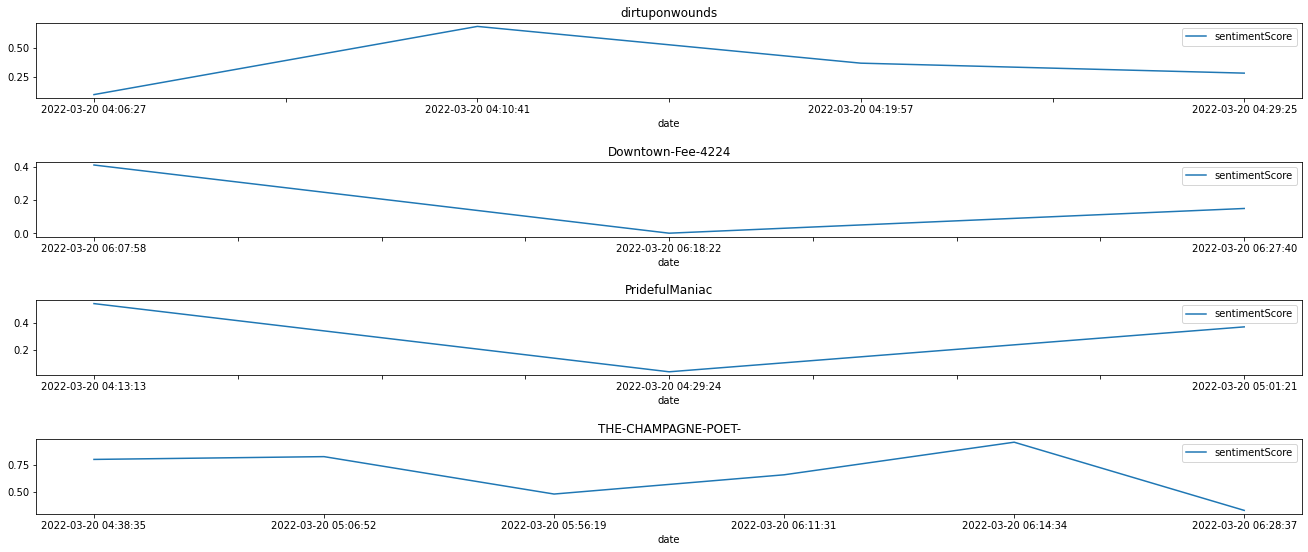

In [80]:
import random

def hello(duplicatePosts, count):
    
    fig, axs = subplots(count)
    fig.tight_layout()
    
    duplicatePosts = duplicatePosts.reset_index(drop=True)
    
    names = duplicatePosts.user_id.unique()
    random.shuffle(names)
    
    for y, x in enumerate(names[0:count]):
        tina = duplicatePosts[duplicatePosts["user_id"] == x].sort_values("date")
        tina.plot(x='date', y='sentimentScore', kind='line', figsize=(20,8), ax=axs[y])
        axs[y].set_title(f"{x}")
        
    show()

hello(duplicatePosts, 4)